# Obligatorio
<h3>Técnicas de Machine Learning para análisis de datos</h3>

Máster en Big Data - Universidad ORT Uruguay

**Estudiante:**
- Sebastián Uriarte Güimil, N° de estudiante: 194973

**Nota:** La versión más reciente de este obligatorio, así como de los
laboratorios/tareas anteriores, se encuentran disponibles en [este repositorio](https://github.com/sebassu/tecnicas-machine-learning).

### 1. Introducción

El presente obligatorio, entregable final del curso, tiene como objetivo la
aplicación de los distintos conceptos, técnicas y modelos vistos como parte del
contenido de la materia, al análisis de un caso real.

En particular, el  _dataset_ propuesto corresponde a la Encuesta Continua de
Hogares en Uruguay 2022, ya visto en tareas anteriores. Se buscará aplicar
técnicas de aprendizaje automático sobre este para en esta ocasión intentar
predecir en función de sus datos socioeconómicos si una persona es pobre o no,
tratándose por tanto un problema de clasificación.

Asimismo, se excluirán del proceso de entrenamiento datos correspondientes a
ingresos o egresos (gastos) de la persona, buscándose en cambio estudiar la
relación entre las restantes variables y el nivel de pobreza, de forma de
complementar su definición mediante el método del ingreso; es decir, por la
insuficiencia de recursos para acceder a un grupo de necesidades básicas.[¹](https://www.gub.uy/instituto-nacional-estadistica/sites/instituto-nacional-estadistica/files/documentos/publicaciones/Informe%20Linea%20de%20Pobreza%202006%20Final.pdf)

Los resultados del trabajo llevado a cabo se exponen a continuación.



### 2. Análisis exploratorio

##### 2.1 Carga de los datos

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [3]:
data = pd.read_csv(r'data/ECH_2022.csv')
data.head()

,ID,nper,anio,mes,GR,region,region_4,dpto,ccz,secc,...,w_tri,w_sem,estred13,nom_dpto,g260,g261,g261_1,w_ano,Loc_agr_13,Nom_loc_agr_13
0,11558,1,2022,1,7,1,1,1,1,4,...,175,87.5,4,MONTEVIDEO,NaN,NaN,NaN,38,1010,Montevideo
1,11559,1,2022,1,7,1,1,1,1,4,...,350,175.0,4,MONTEVIDEO,NaN,NaN,NaN,84,1010,Montevideo
2,11559,2,2022,1,7,1,1,1,1,4,...,350,175.0,4,MONTEVIDEO,NaN,NaN,NaN,84,1010,Montevideo
3,11560,1,2022,1,7,1,1,1,1,4,...,131,65.5,4,MONTEVIDEO,NaN,NaN,NaN,33,1010,Montevideo
4,11561,1,2022,1,7,1,1,1,1,4,...,131,65.5,4,MONTEVIDEO,NaN,NaN,NaN,33,1010,Montevideo


In [237]:
data.shape

(55056, 528)

Vemos entonces que el _dataset_ original es uno bastante grande, con 528 columnas,
y más de cincuenta mil filas. De esas columnas, seleccionaremos las que resultarán
útiles para el problema a abordar, excluyéndose las que la propuesta menciona como
no utilizables, y aquellas que tengan que ver con IDs, etc.

In [4]:
columns_to_select = [
    "dpto", "secc", "segm", "ccz", "region", "region_4", "estred13", "c1", "c2",
    "c3", "c4", "c6", "d8_1", "d9", "d10", "d11", "d12", "d13", "d14", "d15",
    "d16", "d18", "d260", "d19", "d20", "d21_1", "d21_2", "d21_3", "d21_4",
    "d21_4_1", "d21_5", "d21_5_1", "d21_6", "d21_20", "d21_7", "d21_10",
    "d21_11", "d21_12", "d21_13", "d21_14", "d21_14_1", "d21_15", "d21_15_1",
    "d21_15_2", "d21_15_3", "d21_15_4", "d21_15_5", "d21_15_6", "d21_16",
    "d21_16_1", "d21_16_2", "d21_21", "d21_17", "d21_18", "d21_18_1", "d21_19",
    "d21_19_1", "d181", "d229", "d230", "d231", "d232", "d184", "d184_1", "d23", 
    "d24", "d25", "h155", "h156", "h252", "h158_1", "h158_2", "h159", "h160",
    "h161", "h162", "h227", "h269", "h167_1", "h167_2", "h167_3", "h167_4",
    "h169", "h271", "h171", "h171_2", "h172", "h173", "i228", "i259", "HT19",
    "pobre"
]

data = data[columns_to_select]
data.head()

,dpto,secc,segm,ccz,region,region_4,estred13,c1,c2,c3,...,h169,h271,h171,h171_2,h172,h173,i228,i259,HT19,pobre
0,1,4,103,1,1,1,4,3,1,1,...,2,2,2,0,2,2,2,2,1,0
1,1,4,103,1,1,1,4,3,1,1,...,2,2,2,0,2,2,2,2,2,0
2,1,4,103,1,1,1,4,3,1,1,...,2,2,2,0,2,2,2,2,2,0
3,1,4,103,1,1,1,4,3,1,1,...,2,2,2,0,2,2,2,2,1,0
4,1,4,103,1,1,1,4,3,1,1,...,2,2,2,0,2,2,2,2,1,0


Esta información, así como la explicación de a que contenido corresponde cada
código de columna, se obtuvo del archivo `DICCIONARIO ECH 2022_propuesto.xlsx`,
presentado como parte de la propuesta del obligatorio.

In [239]:
print(f'Dataset tiene nulos: {data.isnull().any().any()}')
print(f'Dataset tiene NaNs: {data.isna().any().any()}')
set(data.dtypes)

Dataset tiene nulos: False
Dataset tiene NaNs: False


{dtype('int64')}

Con esto verificamos que, dentro de las columnas seleccionadas, no existen
celdas nulas, lo cual hace innecesario el tener que rellenar valores faltantes.
Por otro lado, correspondería verificar y ajustar de ser necesario el tipo de
cada una de estas columnas (que, como podemos ver arriba, se han cargado todas
con el tipo `int64`), de la siguiente forma:

In [5]:
for column in ["dpto", "secc", "segm", "ccz", "estred13", "d8_1", "d11"]:
    data[column] = data[column].astype('category')

for column in ["d15", "d21_1", "d21_2", "d21_3", "d21_4", "d21_5", "d21_6",
               "d21_20", "d21_7", "d21_10", "d21_11", "d21_12", "d21_13",
               "d21_14", "d21_15", "d21_15_1", "d21_15_3", "d21_15_5", "d21_16",
               "d21_16_1", "d21_16_2", "d21_21", "d21_17", "d21_18", "d21_19",
               "d181", "d231", "d184", "h155", "h156", "h252", "h159", "h160",
               "h161", "h162", "h227", "h269", "h167_2", "h167_3", "h167_4",
               "h169", "h271", "h171", "h167_2", "h167_3", "h167_4", "h169",
               "h271", "h171", "h172", "h173", "i228", "i259"]:
    data[column] = data[column].replace({1: True, 2: False}).astype(bool)

three_dtype = pd.CategoricalDtype(categories=list(range(1, 4)), ordered=True)
for column in ['region', 'd13', 'd19', 'h167_1']:
    data[column] = data[column].astype(three_dtype)

four_dtype = pd.CategoricalDtype(categories=list(range(1, 5)), ordered=True)
for column in ['region_4', 'd12', 'd18']:
    data[column] = data[column].astype(four_dtype)

five_dtype = pd.CategoricalDtype(categories=list(range(1, 6)), ordered=True)
data['c1'] = data['c1'].astype(five_dtype)
data['c4'] = data['c4'].astype(five_dtype)

six_dtype = pd.CategoricalDtype(categories=list(range(1, 7)), ordered=True)
for column in ['c2', 'c3', 'd20']:
    data[column] = data[column].astype(six_dtype)

seven_dtype = pd.CategoricalDtype(categories=list(range(1, 8)), ordered=True)
data['d260'] = data['d260'].astype(seven_dtype)

d16_dtype = pd.CategoricalDtype(categories=list(range(0, 5)), ordered=True)
data['d16'] = data['d16'].astype(d16_dtype)

data['pobre'] = data['pobre'].astype(bool)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55056 entries, 0 to 55055
Data columns (total 92 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   dpto      55056 non-null  category
 1   secc      55056 non-null  category
 2   segm      55056 non-null  category
 3   ccz       55056 non-null  category
 4   region    55056 non-null  category
 5   region_4  55056 non-null  category
 6   estred13  55056 non-null  category
 7   c1        55056 non-null  category
 8   c2        55056 non-null  category
 9   c3        55056 non-null  category
 10  c4        55056 non-null  category
 11  c6        55056 non-null  int64   
 12  d8_1      55056 non-null  category
 13  d9        55056 non-null  int64   
 14  d10       55056 non-null  int64   
 15  d11       55056 non-null  category
 16  d12       55056 non-null  category
 17  d13       55056 non-null  category
 18  d14       55056 non-null  int64   
 19  d15       55056 non-null  bool    
 20  d16   

In [246]:
data.describe()

,c6,d9,d10,d14,d21_4_1,d21_5_1,d21_14_1,d21_15_2,d21_15_4,d21_15_6,...,d230,d232,d184_1,d23,d24,d25,h158_1,h158_2,h171_2,HT19
count,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,...,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000,55056.000000
mean,1.006884,3.585077,2.182142,1.214454,0.143581,1.518799,0.770670,0.421516,0.732400,0.050658,...,1.334496,0.001726,0.631757,2.485469,0.669137,3.154606,0.645670,0.600843,0.024920,3.157821
std,0.082684,1.188153,0.821709,0.543168,0.413908,0.967143,1.066753,0.767812,1.006224,0.250681,...,6.768846,0.043637,4.192585,1.120498,0.986633,1.564489,0.627782,0.946715,0.235363,1.564394
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,3.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000
50%,1.000000,3.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,0.000000,0.000000,3.000000
75%,1.000000,4.000000,3.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,1.000000,4.000000,1.000000,2.000000,0.000000,4.000000
max,2.000000,14.000000,7.000000,6.000000,4.000000,8.000000,10.000000,6.000000,8.000000,5.000000,...,168.000000,2.000000,99.000000,10.000000,8.000000,12.000000,7.000000,12.000000,7.000000,12.000000


##### 2.2 Exploración

Como se ha mencionado anteriormente, el objetivo de este obligatorio es entrenar
modelos que, tomando como entrada los datos socioeconómicos de una persona,
permitan predecir si esta es pobre o no. Esto se encuentra codificado en el
_dataset_ bajo la columna `pobre`, de tipo booleano (`False` si no es pobre, y
`True` si sí lo es). Este es entonces el problema de clasificación a abordar.

En cuanto a eso, resultará interesante determinar cuantos ejemplos de una u otra
clase se encuentran en el dataset. Tenemos entonces:


pobre
False    50408
True      4648
Name: count, dtype: int64

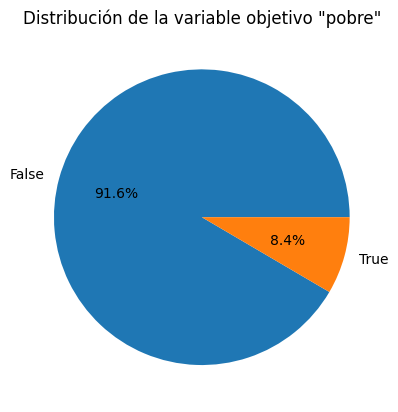

In [247]:
counts = data['pobre'].value_counts()
display(counts)

plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribución de la variable objetivo "pobre"')
plt.show()

Como era tal vez esperable, el _dataset_ no se encuentra balanceado entre estas
dos clases, sino que existe una mucho mayor proporción (superior a 10 veces
mayor) de filas con la etiqueta `False` (es decir, no pobres). Esto es un dato
relevante a la hora de seleccionar o definir que métricas utilizar sobre el
entrenamiento a realizarse, y de como hacer el _split_ del dataset.

,dpto,secc,segm,ccz,region,region_4,estred13,c1,c2,c3,...,h169,h271,h171,h171_2,h172,h173,i228,i259,HT19,pobre
dpto,1.000000,-0.400957,-0.153567,-0.559377,0.604263,0.553336,0.695156,-0.300561,0.066932,0.371014,...,-0.022782,-0.024533,-0.039160,-0.026829,-0.028279,-0.023805,0.003287,-0.063408,0.022154,-0.035550
secc,-0.400957,1.000000,0.173219,0.293082,-0.302664,-0.283459,-0.410899,0.125602,-0.015130,-0.169313,...,0.007469,0.006403,0.044287,0.028944,0.020616,0.014545,0.023106,0.044828,-0.002162,0.014961
segm,-0.153567,0.173219,1.000000,0.055780,-0.116652,-0.125733,-0.178094,0.076475,-0.009130,-0.116504,...,-0.001787,-0.000822,0.018429,0.016000,0.009703,0.001516,-0.006151,-0.009415,0.017347,0.004086
ccz,-0.559377,0.293082,0.055780,1.000000,-0.711200,-0.654000,-0.778741,0.207474,-0.020543,-0.240222,...,0.013169,0.018387,0.020617,0.012797,0.017807,0.000704,0.001641,0.024018,0.030642,0.140373
region,0.604263,-0.302664,-0.116652,-0.711200,1.000000,0.968862,0.758034,-0.399706,0.082240,0.436108,...,-0.034283,-0.031093,-0.020299,-0.011737,-0.036158,-0.012815,-0.008799,-0.067219,0.029731,-0.058522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
h173,-0.023805,0.014545,0.001516,0.000704,-0.012815,-0.012805,-0.010985,0.011997,-0.010937,-0.025537,...,-0.003873,-0.001907,-0.000249,0.001061,0.025882,1.000000,0.026046,0.017777,0.016567,-0.009047
i228,0.003287,0.023106,-0.006151,0.001641,-0.008799,-0.010455,-0.001541,0.003286,-0.010576,0.002240,...,0.011628,0.001042,0.021059,0.018599,0.019280,0.026046,1.000000,0.011849,-0.006392,-0.044649
i259,-0.063408,0.044828,-0.009415,0.024018,-0.067219,-0.060299,-0.053030,0.042693,-0.029168,-0.081817,...,0.029917,0.003270,-0.000156,0.002718,0.028857,0.017777,0.011849,1.000000,-0.052147,-0.070278
HT19,0.022154,-0.002162,0.017347,0.030642,0.029731,0.027007,-0.025418,-0.127886,0.085391,0.146613,...,-0.003403,-0.003880,0.031135,0.047036,0.004740,0.016567,-0.006392,-0.052147,1.000000,0.259440


<Axes: >

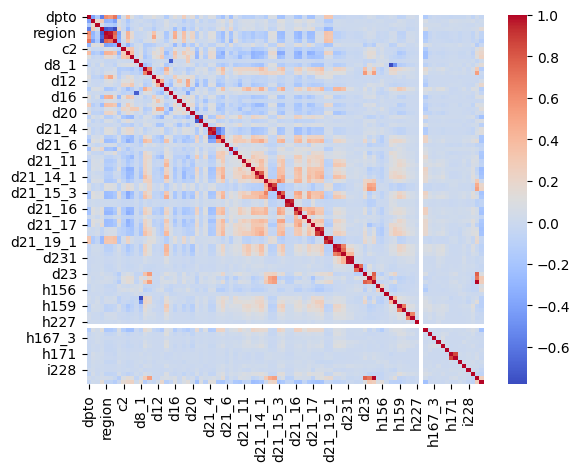

In [248]:
correlation_matrix = data.corr()
display(correlation_matrix)

sns.heatmap(correlation_matrix, cmap='coolwarm')

pobre     1.000000
d24       0.300414
HT19      0.259440
d25       0.258420
c4        0.233785
            ...   
d21_1    -0.216368
d21_18   -0.219739
d21_14   -0.226634
d21_13   -0.243758
h269           NaN
Name: pobre, Length: 92, dtype: float64

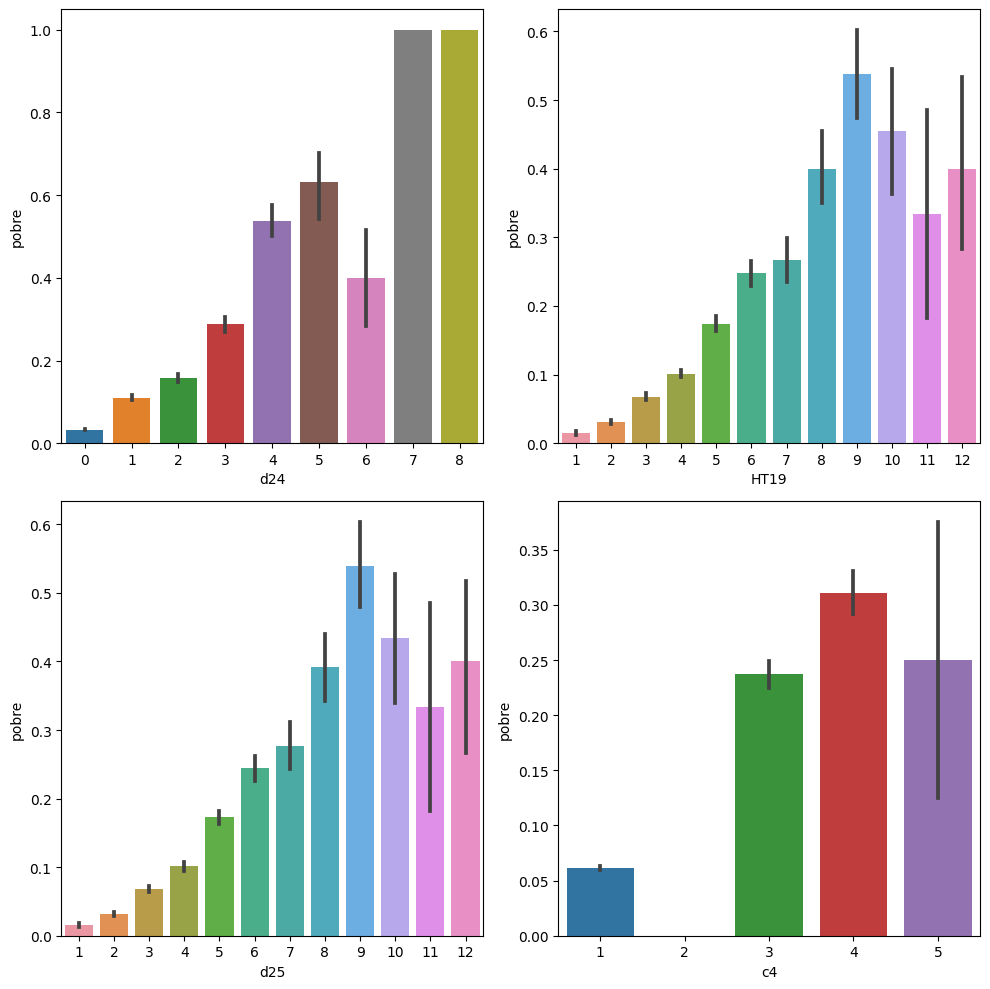

In [249]:
display(correlation_matrix['pobre'].sort_values(ascending=False))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
sns.barplot(x='d24', y='pobre', data=data, ax=axes[0, 0])
sns.barplot(x='HT19', y='pobre', data=data, ax=axes[0, 1])
sns.barplot(x='d25', y='pobre', data=data, ax=axes[1, 0])
sns.barplot(x='c4', y='pobre', data=data, ax=axes[1, 1])
plt.tight_layout()
plt.show()

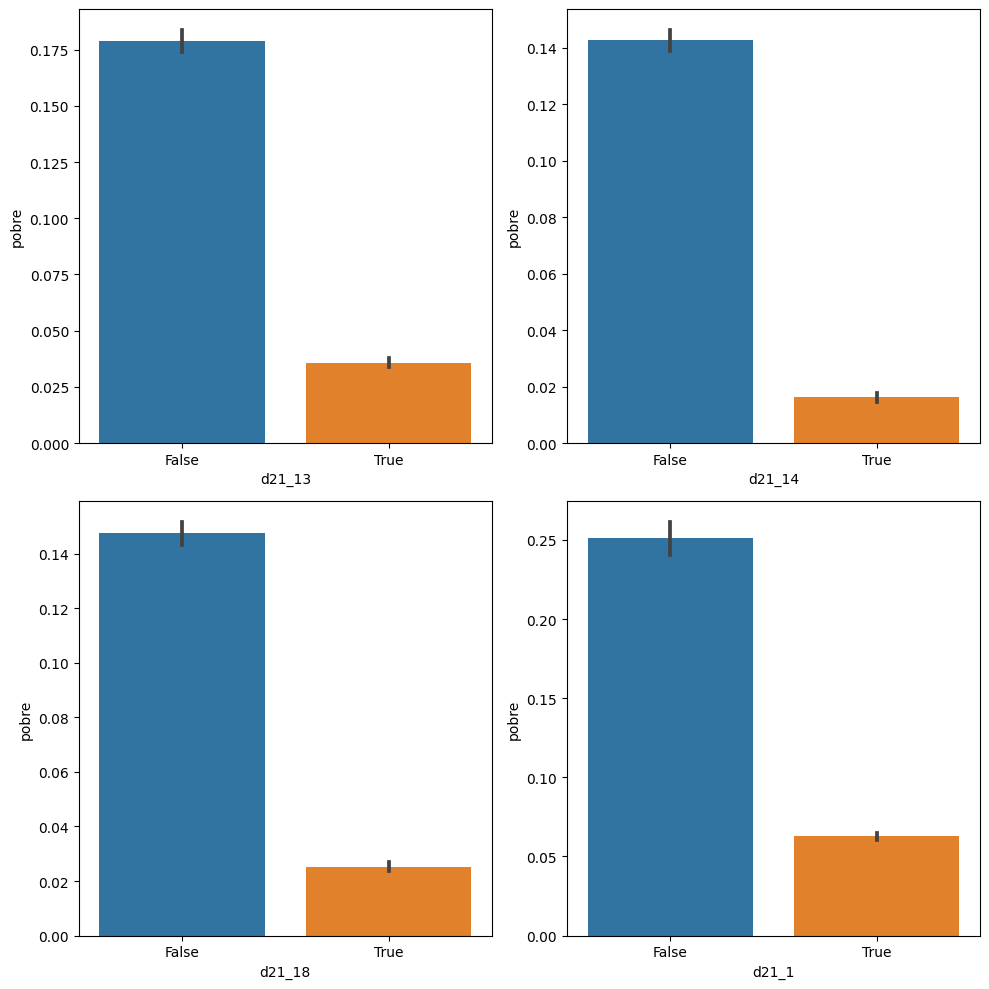

In [250]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
sns.barplot(x='d21_13', y='pobre', data=data, ax=axes[0, 0])
sns.barplot(x='d21_14', y='pobre', data=data, ax=axes[0, 1])
sns.barplot(x='d21_18', y='pobre', data=data, ax=axes[1, 0])
sns.barplot(x='d21_1', y='pobre', data=data, ax=axes[1, 1])
plt.tight_layout()
plt.show()

En las celdas superiores, se intentó determinar y visualizar la correlación que
existe entre las distintas columnas del _dataset_. Lo que parece concluirse 
de la matriz de correlación calculada, es que aparentemente no existiría gran
correlación entre cada una de las variables del mismo (solo entre algunas pocas
que es entendible que así sea, como `dpto` y `region`), ni con respecto a la
variable objetivo `pobre`.

Tomando como umbral para esto un valor de `0.5` (pudiéndose obtener resultados
dentro del intervalo `[-1, 1]`), vemos que respecto de la variable `pobre` 
todos están por debajo. Esto parecería indicar que ninguna de las variables del
dataset explicaría completamente a la variable objetivo, sino siendo en cambio
una combinación o relación entre ellas lo que podría llegar a predecirla. Desde
el punto de vista de la realidad modelada por el _dataset_ esta conclusión
podría llegar a tener sentido: una persona puede no ser pobre a pesar de tener
pisos de cemento expuesto en su hogar, pero si además ilumina con velas, no
tiene agua corriente, etc., quizás sí lo sea.

Luego de eso, se graficó a la variable objetivo en función de algunas que
demostraron los mayores coeficientes de correlación. En estas gráficas de
barras, se observa que efectivamente parece haber alguna relación entre estas
variables.

Por ejemplo, respecto de la columna `d24`, que corresponde a
**"Cantidad de personas menores de 14 años"** en el hogar, o `HT19`,
**"Cantidad de personas sin servicio doméstico"**. Parece concluirse que
cuanto mayor este número, mayor la probabilidad de que la persona sea pobre, lo
cual puede tener cierto sustento. Otro ejemplo es la columna `d21_13`, que
corresponde a si cuenta con **Horno microondas**. Aparentemente, esta variable
de ser `True`, hace bastante improbable que la persona sea pobre, lo que, de
nuevo, parece ser una conclusión razonable o consistente con lo que en la
realidad parecería ocurrir.


### 3. Entrenamiento

En cuanto al entrenamiento de los modelos que deberá hacerse, una posible
pregunta a tratarse es la posibilidad de modificar los datos, por ejemplo
agregándose nuevas columnas. Dado que el _dataset_ cuenta con 92 columnas, no
parecería ser necesario agregar más; al contrario, podría explorarse la
posibilidad de reducir este número eliminando las columnas con menor correlación
con la variable objetivo. Esto conllevaría menor uso de memoria y una posible
mayor velocidad en los algoritmos de entrenamiento, haciéndolo más rápido.

Asimismo, otro problema es el mencionado desbalanceo de clases que hay en las
filas del _dataset_ respecto de la variable objetivo, dado que, como se ha
visto, es mucho mayor el número de personas no pobres encuestadas que de
personas pobres. Una opción es utilizar el parámetro `class_weight` que muchos
modelos de `sklearn` ofrecen, que penalizan con distintos coeficientes a errores
según pertenezcan a una u otra clase.

Otra opción es el hacer uso de algoritmos para permitir intentar balancear un 
_dataset_ desbalanceado, mediante mecanismos como __oversampling__ y 
__undersampling__, es decir, o bien generar duplicados o filas sintéticas de la
clase en menor proporción, o eliminar filas de la clase en mayor proporción.
Librerías como `imblearn` brindan esta funcionalidad, dejándose como tarea
futura la investigación de la misma, debido a problemas de compatibilidad entre
librerías que no han aún hasta el momento podido ser resueltos.

In [6]:
X = data.drop('pobre', axis=1)
y = data['pobre']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

def test_model_with(model, parameters: dict):
    search = GridSearchCV(model, parameters, scoring='f1', cv=5)
    search.fit(X_train, y_train)
    print(f'Best params: {search.best_params_}')
    print(f'Best score: {search.best_score_}')

    y_pred = search.best_estimator_.predict(X_test)
    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}\n")
    print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}\n")
    print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
    return search.best_estimator_

#### 3.1 _Decision Tree_

Best params: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4}
Best score: 0.8737593362740318
Accuracy score: 0.9819093286835222

Confusion Matrix:
 [[12414   188]
 [   61  1101]]

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      0.99     12602
        True       0.85      0.95      0.90      1162

    accuracy                           0.98     13764
   macro avg       0.92      0.97      0.94     13764
weighted avg       0.98      0.98      0.98     13764


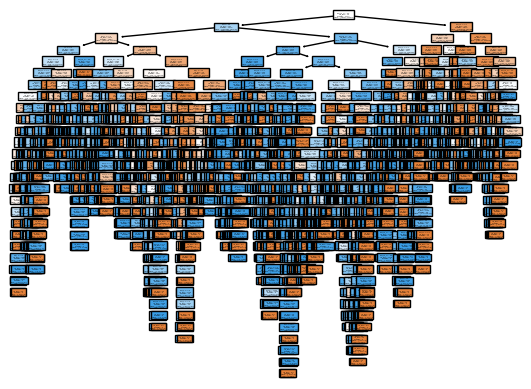

In [8]:
model = DecisionTreeClassifier()
parameters = {
    'criterion': ['gini', 'log_loss'],
    'max_depth': [None, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 4, 6],
    'class_weight': ['balanced']
}

best_decision_tree = test_model_with(model, parameters)
plot_tree(best_decision_tree, filled=True, feature_names=X.columns.tolist(), class_names=['No pobre', 'Pobre'])
plt.show()

#### 3.2 _Logistic Regression_

In [16]:
model = LogisticRegression()
parameters = {
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'C': [0.1, 1, 10],
    'max_iter': [100, 300, 500],
    'class_weight': ['balanced']
}

best_logistic_regression = test_model_with(model, parameters)

Best params: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.4907331160307501
Accuracy score: 0.8478639930252834

Confusion Matrix:
 [[10666  1936]
 [  158  1004]]

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.85      0.91     12602
        True       0.34      0.86      0.49      1162

    accuracy                           0.85     13764
   macro avg       0.66      0.86      0.70     13764
weighted avg       0.93      0.85      0.88     13764


#### _3.3 Random Forest_

In [21]:
model = RandomForestClassifier()
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10],
    'min_samples_split': [2, 6],
    'min_samples_leaf': [1, 4],
    'class_weight': ['balanced']
}

best_random_forest = test_model_with(model, parameters)

Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.9447382048056243
Accuracy score: 0.9943330427201394

Confusion Matrix:
 [[12602     0]
 [   78  1084]]

Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      1.00     12602
        True       1.00      0.93      0.97      1162

    accuracy                           0.99     13764
   macro avg       1.00      0.97      0.98     13764
weighted avg       0.99      0.99      0.99     13764


#### 3.4 _Gradient Boosting_

In [33]:
model = GradientBoostingClassifier()
parameters = {
    'learning_rate': [0.2, 0.1, 0.05],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10],
}

best_gradient_boosting = test_model_with(model, parameters)

Best params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
Best score: 0.9455488482175334
Accuracy score: 0.9948416158093577

Confusion Matrix:
 [[12594     8]
 [   63  1099]]

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     12602
        True       0.99      0.95      0.97      1162

    accuracy                           0.99     13764
   macro avg       0.99      0.97      0.98     13764
weighted avg       0.99      0.99      0.99     13764


#### 3.5 _Linear-Support Vector Classification_

In [30]:
model = LinearSVC()
parameters = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced'],
    'dual': [False]  
}

best_linear_svc = test_model_with(model, parameters)

Best params: {'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
Best score: 0.4878035131350689
Accuracy score: 0.8465562336530078

Confusion Matrix:
 [[10647  1955]
 [  157  1005]]

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.84      0.91     12602
        True       0.34      0.86      0.49      1162

    accuracy                           0.85     13764
   macro avg       0.66      0.85      0.70     13764
weighted avg       0.93      0.85      0.87     13764


#### 3.6 _SGD Classifier_

In [38]:
model = SGDClassifier()
parameters = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'perceptron'],
    'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2'],
    'learning_rate': ['constant', 'optimal', 'adaptive'],
    'max_iter': [1000, 2000, 4000],
    'class_weight': ['balanced'],
}

best_sgd_classifier = test_model_with(model, parameters)

Best params: {'alpha': 1e-05, 'class_weight': 'balanced', 'learning_rate': 'optimal', 'loss': 'log_loss', 'max_iter': 2000, 'penalty': 'l2'}
Best score: 0.4228037078459227
Accuracy score: 0.7643126997965708

Confusion Matrix:
 [[9473 3129]
 [ 115 1047]]

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.75      0.85     12602
        True       0.25      0.90      0.39      1162

    accuracy                           0.76     13764
   macro avg       0.62      0.83      0.62     13764
weighted avg       0.93      0.76      0.81     13764


#### 3.7 _K-Neighbors_

In [25]:
model = KNeighborsClassifier()
parameters = {
    'n_neighbors': [3, 5, 7, 15, 30, 50, 70, 100],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3],
}

best_k_neighbors = test_model_with(model, parameters)

Best params: {'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
Best score: 0.9425897340924354
Accuracy score: 0.993897122929381

Confusion Matrix:
 [[12595     7]
 [   77  1085]]

Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      1.00     12602
        True       0.99      0.93      0.96      1162

    accuracy                           0.99     13764
   macro avg       0.99      0.97      0.98     13764
weighted avg       0.99      0.99      0.99     13764


#### 3.8 _Gaussian Naive Bayes_

In [9]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

y_pred = gaussian_nb.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}\n")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

Accuracy score: 0.5422842197035745

Confusion Matrix:
 [[6354 6248]
 [  52 1110]]

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.50      0.67     12602
        True       0.15      0.96      0.26      1162

    accuracy                           0.54     13764
   macro avg       0.57      0.73      0.46     13764
weighted avg       0.92      0.54      0.63     13764


#### 3.9 _Ada Boost_

In [17]:
model = AdaBoostClassifier()
parameters = {
    'n_estimators': [25, 50, 100, 200, 300, 500, 1000],
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2],
}

best_ada_boost = test_model_with(model, parameters)

Best params: {'learning_rate': 1.0, 'n_estimators': 300}
Best score: 0.5635412181822732
Accuracy score: 0.9387532693984307

Confusion Matrix:
 [[12362   240]
 [  603   559]]

Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.98      0.97     12602
        True       0.70      0.48      0.57      1162

    accuracy                           0.94     13764
   macro avg       0.83      0.73      0.77     13764
weighted avg       0.93      0.94      0.93     13764


En este caso, se han entrenado modelos de distintos tipos utilizando _grid search_
como forma de evaluar distintos hiperparámetros para cada uno, quedándonos con el
ejemplar más exitoso en cada caso. Se utilizaron 5 _folds_ para _cross validation_,
como forma de entrenar el modelo sobre subconjuntos de los datos de entrenamiento y
validarlo sobre el conjunto restante. Esto puede resultar útil para obtener modelos
más robustos.

Asimismo, como métrica para evaluar estos modelos, se utilizó el
**F1 score**, la media harmónica de _precision_ y _recall_. Esto debido a que no
resulta evidente, en el contexto de negocio de esta propuesta, si es necesario penalizar
errores del modelo más hacia una clase o hacia la otra, respecto de falsos positivos
o negativos. Esta es una métrica que ofrece un balance en este sentido.
Además, parece tener un comportamiento adecuado para _datasets_ inbalanceados.

Lo que restaría entonces es analizar que resultados se obtienen al combinar estos
modelos mediante métodos de _stacking_.